In [97]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import os
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


! pip install kaggle
! kaggle competitions download -c digit-recognizer -f train.csv
! unzip -o train.csv.zip
! kaggle competitions download -c digit-recognizer -f test.csv
! unzip -o test.csv.zip
! kaggle competitions download -c digit-recognizer -f sample_submission.csv
! unzip -o sample_submission.csv.zip


! rm train.csv.zip
! rm test.csv.zip
! rm sample_submission.csv.zip


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 164MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 112MB/s]
Archive:  test.csv.zip
  inflating: test.csv                
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open sample_submission.csv.zip, sample_submission.csv.zip.zip or sample_submission.csv.zip.ZIP.
rm: cannot remove 'sample_submission.csv.zip': No such file or directory


In [107]:
class MyCustomImageDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.images = torch.tensor(self.data.loc[:, self.data.columns != "label"].values) / 255
        self.labels = torch.tensor(self.data.loc[:, "label"].values)
        self.transform = None
        self.target_transform = None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx, :]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


data = pd.read_csv("train.csv")
train, val = train_test_split(data, test_size=0.15)
    
data_train = MyCustomImageDataset(
  data = train    
)

data_val = MyCustomImageDataset(
  data = val
)

batch_size = 64
train_loader  = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(data_val, batch_size=batch_size, shuffle=True)

In [ ]:
print(f"Train size: {len(train_loader)}")
print(f"Val size: {len(val_loader)}")
for X, y in train_loader:
    print(f"Shape of X: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

for X, y in train_loader:
    img0 = X[0, :]
    label0 = y[0]
    plt.imshow(img0.view(28, 28))
    plt.title(f"Label: {label0}")
    break
plt.show

In [112]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_tanh_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (linear_tanh_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [113]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


In [114]:
losses = []

Epoch 1
-------------------------------
loss: 0.310650  [   64/35700]
loss: 0.290913  [ 6464/35700]
loss: 0.571807  [12864/35700]
loss: 0.415600  [19264/35700]
loss: 0.357539  [25664/35700]
loss: 0.476314  [32064/35700]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.402623 

Epoch 2
-------------------------------
loss: 0.519645  [   64/35700]
loss: 0.382298  [ 6464/35700]
loss: 0.185549  [12864/35700]
loss: 0.301423  [19264/35700]
loss: 0.287412  [25664/35700]
loss: 0.399418  [32064/35700]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.400924 

Epoch 3
-------------------------------
loss: 0.440974  [   64/35700]
loss: 0.367568  [ 6464/35700]
loss: 0.388562  [12864/35700]
loss: 0.391146  [19264/35700]
loss: 0.385599  [25664/35700]
loss: 0.336417  [32064/35700]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.401565 

Epoch 4
-------------------------------
loss: 0.270372  [   64/35700]
loss: 0.249216  [ 6464/35700]
loss: 0.339110  [12864/35700]
loss: 0.453087  [19264/35700]
loss: 0.361949  [25664/3

Text(0, 0.5, 'cross entropy')

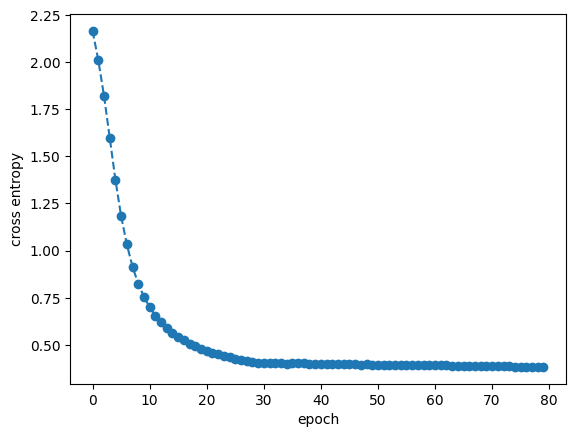

In [117]:
learning_rate = 1e-4
batch_size = 64
epochs = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    loss = val_loop(val_loader, model, loss_fn)
    losses.append(loss)
print("Done!")
plt.plot(losses, '--o')
plt.xlabel('epoch')
plt.ylabel('cross entropy')

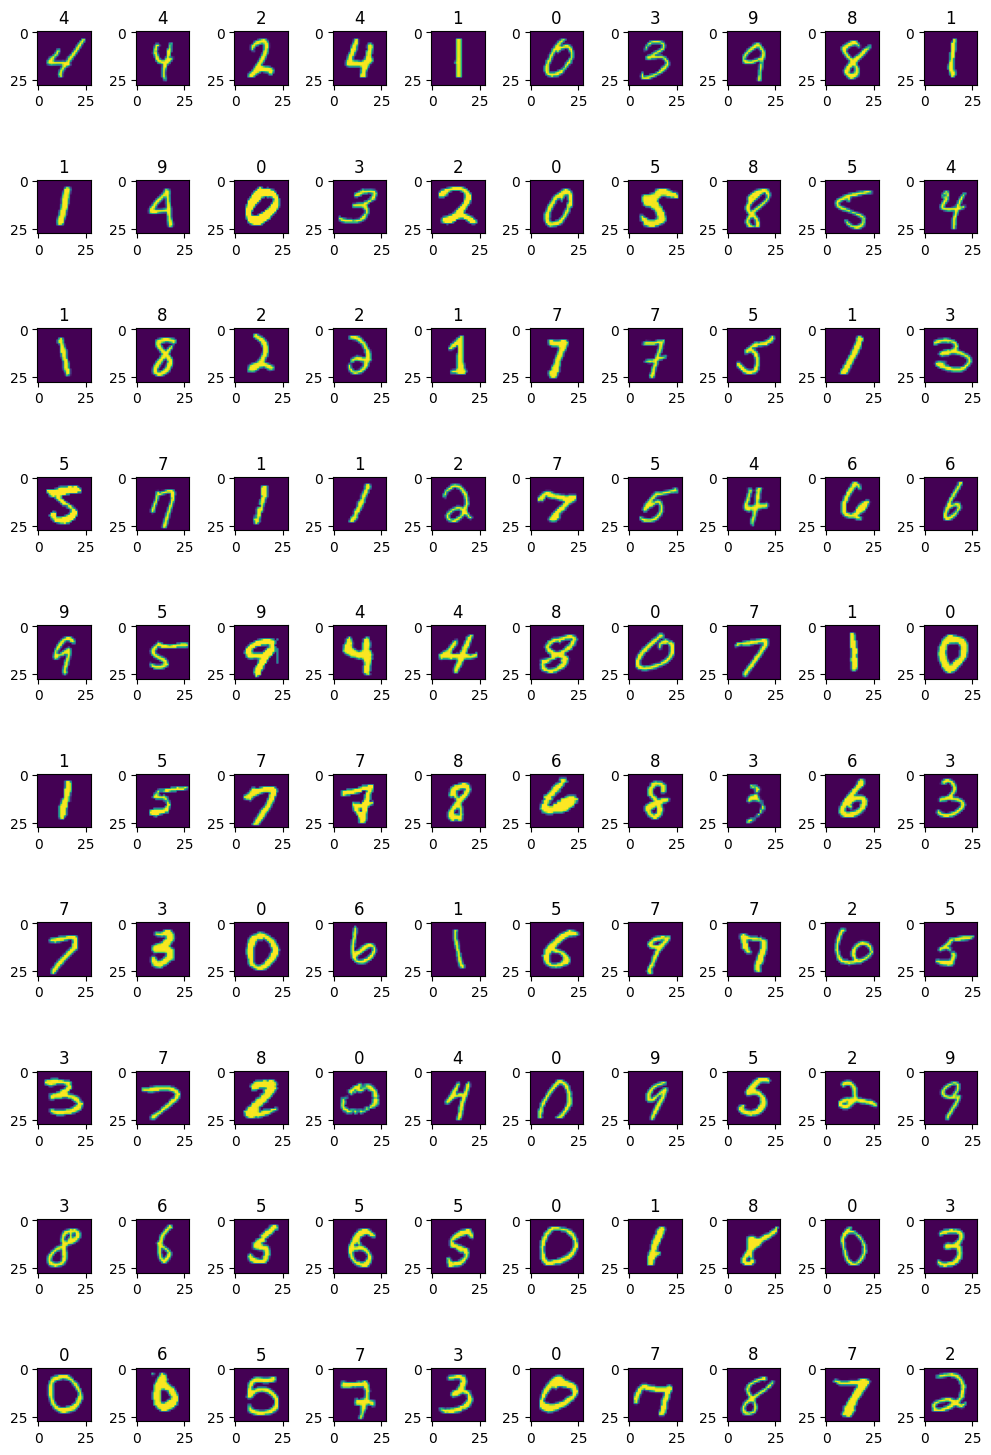

In [73]:
# sample from val set
xs, ys = data_val[0:100]
yhats = model(xs).argmax(axis=1)

ncols, nrows = 10, 10
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 15))
for i in range(ncols*nrows):
  plt.subplot(ncols, nrows, i + 1, )
  plt.imshow(xs[i].view(28, 28))
  plt.title(f"{yhats[i]}")

fig.tight_layout()


In [96]:
data = pd.read_csv("test.csv")
images = torch.tensor(data.values) / 255
yhats = model(images).argmax(axis=1)

df = pd.DataFrame({'ImageId': list(range(1, len(yhats)+1)), 'Label': yhats}) #convert to a dataframe
df.to_csv("submission.csv",index=False) #save to file


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,2
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


# New Section